## 线性回归

在之前的CS229中，线性回归（Linear regression）作为机器学习的Hello world，让我们了解到学习模型（supervised learning algorithm）会包括几个部分：
1. 数据集（dataset）
2. 假设（hypothesis）
3. 损失函数（loss function）
4. 优化方法（optimization method）

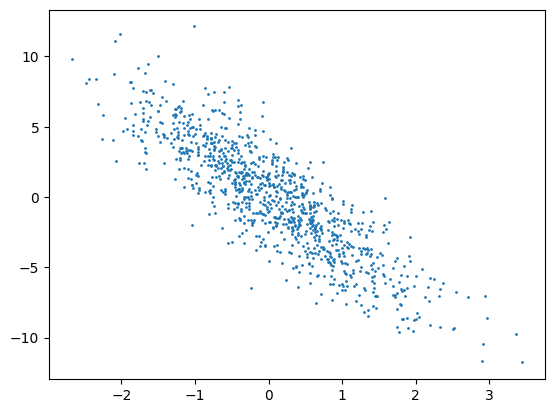

In [1]:
import torch
import matplotlib.pyplot as plt
def gen_data(w,b,num_examples):
    """生成y=Xw+b的噪声"""
    # dtype=float
    X = torch.normal(0,1,(num_examples,len(w)),dtype=float)
    y = torch.matmul(X,w)
    y += torch.normal(0,0.01,y.shape,dtype=float)
    # reshape的意义在于将vector变成为matrix，vector应该是N，而matrix是N*1
    return X,y.reshape((-1,1))
true_w=torch.tensor([2,-3.4],dtype=float)
true_b=4.2
features,labels=gen_data(true_w,true_b,1000)
plt.scatter(features[:,1],labels,1)

## 构建模型
在了解算法的基础上，如何使用代码构建出来是另外一个方面。两者可以是互补的！
参照Tensorflow2.0 八股文的描述，我们将深度学习网络构建的过程也可以分为几个典型的步骤：
1. 构建dataset
2. 根据dataset生成不同的dataloader，方便后续批量梯度下降(batch gradient descent)
3. 建立Model（根据hypothesis）
4. 选择损失函数 loss function
5. 优化器选择
6. 超参数的设置 lr、epoch、batchsize
7. 学习过程，批量梯度下降
8. 评价指标，对于regression的分析常见的包括MSE、MAPE等等


## 2.1 生成数据迭代器
基于Python原生生成的迭代器虽然可以连续的获取不同的小批量，但是执行效率很低，因为此**要求将所有数据加载到内存中，并执行大量的随机内存访问**，所以通常深度学习框架会内置迭代器，用于处理存储在文件中的数据和数据流提供的数据

In [2]:
import random
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 样本随机读取，没有特定的顺序
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size,num_examples)]
        )
        yield features[batch_indices],labels[batch_indices]

# batchsize=10
# for X,y in data_iter(batch_size=batchsize,features=features,labels=labels):
#     '''仅作为测试使用'''
#     print(X,'\n',y)
#     break

## 2.2 定义model
同时也能够返回对应参数的parameters的size，这里和教科书不一样，我们使用class的方式来建立新的模型。


In [3]:
class network:
    def __init__(self) -> None:
        self.w=torch.normal(0,0.01,size=(2,1),requires_grad=True,dtype=float)
        self.b=torch.zeros(1,requires_grad=True,dtype=float)
    
    def predict(self,X):
        return torch.matmul(X,self.w)+self.b
    
    def parameters(self):
        '''返回对应参数的size'''
        return [self.w,self.b]
model=network()

## 2.3 定义损失函数



In [4]:
def get_weight(X,features):
    '''权重分析'''
    diff = X.unsqueeze(-2).unsqueeze(-2)- features.unsqueeze(-2)
    w = torch.exp(-diff**2/0.000002).squeeze(-2).sum(axis=(1,2))
    return w
def square_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2
# y_hat=model.predict(X)
# res=square_loss(y_hat,y)
# res.mean()
def local_loss(y_hat,y,X):
    new_w=get_weight(X,features)
    return new_w.reshape(shape=(-1,1))*(y_hat-y.reshape(y_hat.shape))**2/2

## 2.4 定义优化算法
在计算机求解优化算法的过程中，我们可以先想一下我们需要什么东西？
按照梯度下降的方式来进行神经网络的优化过程中，必然需要知道parameters的size，之后是对参数更新之后的长度learning rate，依旧每次下降的batch-size

In [5]:
def sgd(params,lr,batchsize):
    '''小批量随机梯度下降'''
    # model.eval() 和 with torch.node_grad()区别是什么
    # model.eval()主要用于model的validation过程中，通知dropout和batchnorm层在train
    # val模式之间切换
    # with torch.no_grad()主要是停止autograd模块的工作，起到加速和节省显存的作用
    with torch.no_grad(): #??这是做什么的
        for param in params:
            param -= lr*param.grad/batchsize
            param.grad.zero_()

### 2.5 定义超参数

In [6]:
lr = 0.05
batchsize=10
num_epoches = 4
net = network()
loss = square_loss

## 2.6 开始训练

In [7]:
for epoch in range(num_epoches):
    for X,y in data_iter(batch_size=batchsize,features=features,labels=labels):
        # l = loss(net.predict(X),y)
        l = local_loss(net.predict(X),y,X)
        l.sum().backward()
        sgd(net.parameters(),lr,batchsize)
    with torch.no_grad():
        train_l=loss(net.predict(features),labels).mean()
        print(train_l)


tensor(4.8949e-05, dtype=torch.float64)
tensor(4.9046e-05, dtype=torch.float64)
tensor(5.3049e-05, dtype=torch.float64)
tensor(4.9374e-05, dtype=torch.float64)


In [8]:
print(net.w)

tensor([[ 1.9993],
        [-3.3995]], dtype=torch.float64, requires_grad=True)
